## Classifying YouTube videos for mood by NLP on video comments--a challenging Data Science problem

#### My approach to this challenge was composed of multiple non-trivial steps: deciding on NLP method, preprocessing highly-varied real-world text data, applying the NLP method, and engineering additional data features, due to small video sample size.  

First, three notes: my teammate and I started with no video data and had to manually label mood for 200+ videos. We realized that this might not lead to highly accurate classification. We each created an NLP pipeline for multiclass classification of 6 different moods.

#### For the NLP method, I initially considered Doc2Vec. Given the success of Word2Vec for word embedding and discovering context in text, and that Doc2Vec is built on top of it, Doc2Vec seemed a potentially good choice. Ultimately, due to time constraints, I elected to use TextBlob. See my use of TextBlob further below.

In [ ]:
!pip install -U gensim
from gensim.models import doc2vec, Doc2Vec

#### For Python-driven data science approaches, pandas usage is almost a given. And for text analysis specifically, regular expressions can be invaluable for searching out text patterns.

In [2]:
from collections import OrderedDict
import pandas as pd
import re

Here, we look at an example of a video csv for our YouTube Data API v3-consumed data. Note that values in the "moods" and "labeled" column were manually-labeled (ie, not from YouTube API). 

In [3]:
videos_df = pd.read_csv('new_videos.csv')  # note that this csv data does not have comments column
print(videos_df.shape)
videos_df.head()

(1044, 4)


,video_title,video_id,moods,labeled
0,♩♫ Dramatic Apocalyptic Music ♪♬ - The Wastela...,5eAalHA1bAc,CHILL,t
1,Nostalgy - (No Copyright Music) Sad Cinematic ...,zViXwVZpWqY,SAD,t
2,Under The Radar Copyright Free music for youtu...,ZTgvcaVdw5I,CHILL,t
3,🔥Best of NCS 2017 Mix ♫ Gaming Music Mix ♫ No ...,8ZbrPz_fnXs,CONFIDENT-SASSY,t
4,"[FREE] Lil Baby x Gunna Type Beat 2018 ""Situat...",5vSJTGpG5YM,CHILL,t


I wrote the initial Python code, for this work, to obtain video data above from the YouTube API "search.list" resource. This is the key snippet.

In [ ]:
from googleapiclient.discovery import build

def search_api():
    '''Searches YouTube Data API v3 for videos based on project-specified parameters; returns list of videos.'''
    api_service_name = 'youtube'
    api_version = 'v3'
    DEVELOPER_KEY = 'DEVELOPER_KEY'

    youtube = build(api_service_name, api_version,
                    developerKey = DEVELOPER_KEY)

    request = youtube.search().list(
        part='id,snippet',
        maxResults=50,
        q='instrumental',
        relevanceLanguage='en',
        type='video',
        videoDuration='medium',
        videoLicense='creativeCommon',
    ).execute()

    videos = []

    for search_result in request['items']:
        video_title = search_result['snippet']['title']
        video_id = search_result['id']['videoId']
        videos.append({'video_title': video_title, 'video_id': video_id})

    return videos

My teammate adapted this code to access the YouTube "commentsThread" metadata resource. Speaking of comments, or preprocessing them, actually, is up next.

### Preprocessing the comments data

#### Nothing like working with electronic text to learn (or re-learn) that computing involves symbols that are encoded in different sets, eg, ISO-8859-1, Unicode, and the utf-8 subset of Unicode. Joel Spolsky has a classic [post](https://www.joelonsoftware.com/2003/10/08/the-absolute-minimum-every-software-developer-absolutely-positively-must-know-about-unicode-and-character-sets-no-excuses/). I also found this [Green Notes](https://greeennotebook.wordpress.com/2014/05/24/character-sets-and-unicode-in-python/) post useful.

Here we can see comments data consumed from the YouTube API via "commentsThread".

In [7]:
comments_df = pd.read_csv('video_comments.csv', encoding="utf-8")  # note no moods column
print(comments_df.shape)
comments_df.tail()

(1102, 3)


,id,video_id,comments
1097,5003,7RBDcoSxcgc,"['진격의 방탄 \nwe on, \ntomorrow\n꼭 들어보세요. 안무영상도요..."
1098,5004,1ml_dJ3_A2Q,[]
1099,5005,ThEQZ68sGmw,['😂']
1100,5006,zsR_Yr-wPkM,['Want a Sub? Drop a like and comment. I subsc...
1101,5007,zNWsBvzFstk,"['Awesome bro!', 'Super! Very nice! Thank you ..."


In [10]:
# Examine the raw comments for video 1101
first_vid_comments = comments_df.comments.values[1101]
first_vid_comments  # NOTE: this whole object is a string; change it to a list with strings inside

'[\'Awesome bro!\', \'Super! Very nice! Thank you my friend!\', \'Christmas feeling. So beautiful.\', \'Amazingly good vibes 😍 😍\', "let\'s fun", \'Wouu Happy Christmas\', \'Awesome Great stuff my friend\\nBig Like\', \'Saludos \\nEspero que pases a ver mi último video\\nl https://youtu.be/ei1agzsHFI0\', \'Nice xmas music. Love it.\', \'*Good To Listen, Friend. Regards You.*\', \'Wonderful music video! liked! Have a nice week friend! liked!\', \'Hello, congratulations on your channel. I just registered and I left a like, spare the registration? 😘\', \'Love This!🔥\', \'Christmas time buddy! Boom!\\n🔥🎄🔥💥💪🍒👊🔥\', \'Great one Fantastic al dn pl bk me\', \'yeah beautiful music my bro\', \'Beautiful video...very good music my friend...loveit it <3\', \'Awesome music bro\', \'👌👌 cool Christmas spirit , making jolly music ♪ ♫ ♬ ♫ 🎶 my support.\', \'Nice mate❤\']'

Several features show up in the raw comments above. One is that the entire comments thread is inside single quotes and thus is a string. Another is that " \\' " precedes and follows each full comment in the YouTube commentsThread. New lines are present as "\\n". It's good to know that utf-8 supports emojis (joking). A function will be needed to preprocess each comments thread for each video.

First, I tried this.

In [ ]:
# Study all comments for all videos
# Based on methods from aws-sagemaker-python-notebook [not yet updated on github]
all_comments = []
all_comments_dict = {}
for comment_group in list(comments_df.comments):
    comment_group = comment_group.replace('[', '')
    comment_group = comment_group.replace(']', '')
    comment_group = comment_group.replace("'", '')
    all_comments.append(comment_group)
    
print('length of all_comments is:', len(all_comments))
print(all_comments[:2])

**This** function became the comments preprocessing workhorse for my pipeline, however.

In [12]:
# Convert text to lower-case, do several char replacements, and create list by splitting comments string
# Create a function to do this when applied to all values in df's comments column

def normalize_text(comment_group):
    norm_comment_group = comment_group.lower()
    norm_comment_group = re.sub(r"([\.\",\(\)!\?;:])", " \\1 ", norm_comment_group)
    norm_comment_group = norm_comment_group.replace('\\n', ', ')
    norm_comment_group = norm_comment_group.replace('"', "\'")
    while "\'" in norm_comment_group:
        norm_comment_group = norm_comment_group.replace("\'", '')
    norm_comment_group = norm_comment_group.replace('[', '')
    norm_comment_group = norm_comment_group.replace(']', '')
    return norm_comment_group

# Apply normalize_text function to all comments column values

comments_df.comments = comments_df.comments.apply(lambda x: normalize_text(x))

Note how the words now appear more like natural language text.

In [13]:
comments_df.comments.values[1101]

'awesome bro !  ,  super !  very nice !  thank you my friend !  ,  christmas feeling .  so beautiful .  ,  amazingly good vibes 😍 😍 ,    lets fun   ,  wouu happy christmas ,  awesome great stuff my friend, big like ,  saludos , espero que pases a ver mi último video, l https : //youtu . be/ei1agzshfi0 ,  nice xmas music .  love it .  ,  *good to listen ,  friend .  regards you . * ,  wonderful music video !  liked !  have a nice week friend !  liked !  ,  hello ,  congratulations on your channel .  i just registered and i left a like ,  spare the registration ?  😘 ,  love this ! 🔥 ,  christmas time buddy !  boom ! , 🔥🎄🔥💥💪🍒👊🔥 ,  great one fantastic al dn pl bk me ,  yeah beautiful music my bro ,  beautiful video .  .  . very good music my friend .  .  . loveit it <3 ,  awesome music bro ,  👌👌 cool christmas spirit  ,  making jolly music ♪ ♫ ♬ ♫ 🎶 my support .  ,  nice mate❤'

With preprocessing of the comments metadata for each video now done, time to do some Natural Language Processing to see how informative the comments are about the mood of a given video.

### Trying TextBlob for NLP

#### Traditional approaches to NLP have involved creating a vocabulary of all the unique words in all of the sentences in a given text--here, all the comments for a given video--and then creating a vector (array) of the same length as the vocabulary for each of the sentences. This process is also known as creating a Bag of Words (BoW). It's crucial to know that BoW delivers no information about meaning of a given text nor about the ordering of words in that text. But BoW does give term (word) frequencies, which can be informative. See Rodrigo Stecanella's post [here](https://monkeylearn.com/blog/beginners-guide-text-vectorization/).

Now for [TextBlob](https://textblob.readthedocs.io/en/dev/). Built on the Natural Language Toolkit (nltk) suite and CLiPS pattern module, TextBlob is useful for initial studies in NLP. TextBlob very seamlessly delivers polarity and subjectivity sentiment analysis, part-of-speech tagging of words, tokenization of words or sentences, and many more features.

My use of TextBlob here was specifically for the sentiment analysis and tagging of video comments.

In [14]:
!pip install textblob
from textblob import TextBlob

Initially, I thought to remove stopwords (eg, "the", "a", "this", "that") from tags, to capture more meaningful words.

In [16]:
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from statistics import mean
import numpy as np

While I did not use this stopword filter function, I did use the "top_three_tag_codes" function below to add six features (aka columns) to "comments_df" above.

In [15]:
# Tags can be removed if in nltk stopwords
# To be able to iterate over stopwords, have to put them in an iterable

def tags_filter_stopwords(tags):
    stop_eng = set(stopwords.words('english'))
    stop_esp = set(stopwords.words('spanish'))
    stop_fr = set(stopwords.words('french'))
    stop_de = set(stopwords.words('german'))
    # no stopwords available for Chinese or Japanese
    stop_four = stop_eng.union(stop_esp.union(stop_fr.union(stop_de)))
    tags_list = []
    for tag in tags:
        if tag[0] not in stop_four:
            tags_list.append(tag)
    return tags_list


# Also want to know which parts of speech TextBlob codes are most common among the tags
def top_three_tag_codes(tags):
    """Receives list of tags; returns 3 most common TextBlob parts-of-speech codes"""
    # Recall that each TextBlob tag is a tuple of a word and a TextBlob part-of-speech code
    speech_parts_list = []
    for tag in tags:
        speech_parts_list.append(tag[1])
    c = Counter(speech_parts_list)
    print(c.most_common(3), 'len(c.most_common(3)) is:', len(c.most_common(3)))
    # note that there may only be one most common tag
    return c.most_common(3)  # returns a list of 2-item tuple[s] with code and count for code in tags

Important: **"tags_columns"** here shows *all* of the new columns that I will add to "comments_df" to make the dataframe that I will use to capture data from NLP on the comments data for videos: "analysis_df". 

In [23]:
# Add two new columns to comments_df: one each for TextBlob polarity mean and subjectivity mean
# Want to add other new columns also based on tags:
# one column for each of the top 3, and one column for the count in comments for each of the top 3 

tags_columns = ['polarity_mean', 'subjectivity_mean', 'tags', 'tags_count', 'top_tag', 'top_tag_count',
                'second_tag', 'second_tag_count', 'third_tag', 'third_tag_count']
analysis_df = pd.concat([comments_df, pd.DataFrame(columns=tags_columns)], axis=1)

analysis_df = pd.merge(analysis_df, videos_df, on='video_id')

"analysis_df" is created, but still needs re-ordering of its columns as well as population of values in the columns.

In [25]:
analysis_df.tail()

,id,video_id,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,third_tag_count,video_title,moods,labeled
1039,2904,l8o-DYWmMTg,dope beat ! subbed and liked ! do the same ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,٭HARD٭ DARKEST TRAP TYPE BEAT EVER “WARRIOR...,CHILL,t
1040,4994,_JgUF1RrVqY,hettt itu yg jd jk kondisikan mukanya😂 ngakak ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(HD) 160828 WTF @ KPOP MAKES ONE,HAPPY,NaN
1041,4997,zsFjU-WN4Ww,"yesssss grizzly ! ! ! , fire broo ! 🔥 ,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[TYPE BEATS] ""I'm Back"" 🐻 (SMOOTH) Drake Frees...",CHILL,t
1042,5006,zsR_Yr-wPkM,want a sub ? drop a like and comment . i sub...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Free Smooth Soulful Jay Z x NAS Type Beat ""Jus...",CONFIDENT-SASSY,t
1043,5007,zNWsBvzFstk,"awesome bro ! , super ! very nice ! thank ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Christmas Music Background] Silvermansound - ...,HAPPY,t


In [26]:
analysis_df = analysis_df.drop(['id', 'labeled'], axis=1)

In [27]:
cols = ['video_id', 'video_title', 'comments', 'polarity_mean', 'subjectivity_mean',
        'tags', 'tags_count', 'top_tag', 'top_tag_count', 'second_tag', 'second_tag_count',
        'third_tag', 'third_tag_count', 'moods']

analysis_df = analysis_df[cols]

In [28]:
analysis_df.tail()

,video_id,video_title,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,third_tag_count,moods
1039,l8o-DYWmMTg,٭HARD٭ DARKEST TRAP TYPE BEAT EVER “WARRIOR...,dope beat ! subbed and liked ! do the same ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL
1040,_JgUF1RrVqY,(HD) 160828 WTF @ KPOP MAKES ONE,hettt itu yg jd jk kondisikan mukanya😂 ngakak ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY
1041,zsFjU-WN4Ww,"[TYPE BEATS] ""I'm Back"" 🐻 (SMOOTH) Drake Frees...","yesssss grizzly ! ! ! , fire broo ! 🔥 ,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL
1042,zsR_Yr-wPkM,"Free Smooth Soulful Jay Z x NAS Type Beat ""Jus...",want a sub ? drop a like and comment . i sub...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFIDENT-SASSY
1043,zNWsBvzFstk,[Christmas Music Background] Silvermansound - ...,"awesome bro ! , super ! very nice ! thank ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY


I dropped the videos from the dataframe if they had no comments.

In [29]:
# Drop rows where there are no comments
analysis_df = analysis_df[analysis_df.comments != '']
analysis_df.shape

(746, 14)

These two functions, "get_blob" and "populate_blob_columns", are the **core** of my pipeline. For each video's comments, they process the comments, feed them to TextBlob, and put TextBlob's output data and my feature-engineered tags data into the "analysis_df" dataframe. Getting closer to using "analysis_df" data to train 2 different machine learning classifiers for mood. 

In [30]:
# Add TextBlob mean polarity, mean subjectivity, and tags features for all comments for each video
# Write functions to do each of the following:
# 1) run TextBlob on comments; 2) populate polarity_mean, subjectivity_mean, and tags values

def get_blob(comments):
    """Use with one video's comments at a time."""
    comments = normalize_text(comments)
    blob = TextBlob(comments)
    # tags = tags_filter_stopwords(blob.tags)  # this is functional code but may decrease ML classif. accuracy
    tags = blob.tags
    tags_count = len(tags)
    top_tags = top_three_tag_codes(tags)  # this is a list of 2-item tuple[s]
    top_tag = top_tags[0][0]
    top_tag_count = top_tags[0][1]
    if len(top_tags) < 2:
        second_tag = np.nan
        second_tag_count = 0
        third_tag = np.nan
        third_tag_count = 0
    elif len(top_tags) == 2:
        second_tag = top_tags[1][0]
        second_tag_count = top_tags[1][1]
        third_tag = np.nan
        third_tag_count = 0
    elif len(top_tags) > 2:
        # 3-item list of tuples with each top code and its count
        second_tag = top_tags[1][0]
        second_tag_count = top_tags[1][1]
        third_tag = top_tags[2][0]
        third_tag_count = top_tags[2][1]
    polarity_list = []
    subjectivity_list = []
    for sentence in blob.sentences:
        polarity = sentence.sentiment.polarity
        subjectivity = sentence.sentiment.subjectivity
        if polarity !=0 :
            polarity_list.append(polarity)
        if subjectivity !=0 :
            subjectivity_list.append(subjectivity)
    if len(polarity_list) == 0:
        polarity_list.append(0)
    if len(subjectivity_list) == 0:
        subjectivity_list.append(0)
    # print(top_tag, second_tag)
    return (mean(polarity_list), mean(subjectivity_list), tags, tags_count, top_tag, top_tag_count,
            second_tag, second_tag_count, third_tag, third_tag_count)

def populate_blob_columns(df, comms):
    """Use to fill the polarity_mean, subjectivity_mean, and tags columns."""
    """This was first used successfully on analysis_df."""
    (polarity_mean, subjectivity_mean, tags, tags_count, top_tag, top_tag_count,
            second_tag, second_tag_count, third_tag, third_tag_count) = get_blob(comms)
    df.loc[(df.comments == comms), 'polarity_mean'] = polarity_mean
    df.loc[(df.comments == comms), 'subjectivity_mean'] = subjectivity_mean
    df.loc[(df.comments == comms), 'tags'] = [tags]
    df.loc[(df.comments == comms), 'tags_count'] = tags_count
    df.loc[(df.comments == comms), 'top_tag'] = top_tag
    df.loc[(df.comments == comms), 'top_tag_count'] = top_tag_count
    df.loc[(df.comments == comms), 'second_tag'] = second_tag
    df.loc[(df.comments == comms), 'second_tag_count'] = second_tag_count
    df.loc[(df.comments == comms), 'third_tag'] = third_tag
    df.loc[(df.comments == comms), 'third_tag_count'] = third_tag_count
    
    
for comments in analysis_df.comments.values:
    populate_blob_columns(analysis_df, comments)

[('NN', 43), ('JJ', 19), ('IN', 14)] len(c.most_common(3)) is: 3
[('NN', 40), ('JJ', 10), ('FW', 5)] len(c.most_common(3)) is: 3
[('NN', 180), ('JJ', 51), ('FW', 38)] len(c.most_common(3)) is: 3
[('NN', 43), ('JJ', 16), ('DT', 9)] len(c.most_common(3)) is: 3
[('NN', 65), ('JJ', 31), ('DT', 20)] len(c.most_common(3)) is: 3
[('NN', 117), ('IN', 61), ('DT', 54)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 9), ('VB', 6)] len(c.most_common(3)) is: 3
[('NN', 80), ('JJ', 17), ('FW', 6)] len(c.most_common(3)) is: 3
[('VBP', 2), ('NN', 1), ('PRP', 1)] len(c.most_common(3)) is: 3
[('NN', 12), ('JJ', 5), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 4)] len(c.most_common(3)) is: 1
[('NNP', 19), ('NN', 10), ('CD', 5)] len(c.most_common(3)) is: 3
[('NN', 120), ('NNP', 37), ('IN', 27)] len(c.most_common(3)) is: 3
[('NN', 168), ('IN', 83), ('VB', 83)] len(c.most_common(3)) is: 3
[('NN', 187), ('JJ', 43), ('FW', 39)] len(c.most_common(3)) is: 3
[('NN', 616), ('JJ', 177), ('FW', 109)] len(c.most_c

[('NN', 3), ('VBP', 1), ('DT', 1)] len(c.most_common(3)) is: 3
[('NN', 69), ('JJ', 22), ('NNS', 14)] len(c.most_common(3)) is: 3
[('NN', 26), ('NNP', 11), ('DT', 10)] len(c.most_common(3)) is: 3
[('NN', 42), ('JJ', 3), ('RB', 2)] len(c.most_common(3)) is: 3
[('NN', 15), ('JJ', 10), ('RB', 9)] len(c.most_common(3)) is: 3
[('NN', 2), ('JJ', 2), ('DT', 1)] len(c.most_common(3)) is: 3
[('NN', 16), ('JJ', 12), ('RB', 4)] len(c.most_common(3)) is: 3
[('NN', 3), ('JJ', 2), ('UH', 1)] len(c.most_common(3)) is: 3
[('NN', 54), ('JJ', 17), ('DT', 7)] len(c.most_common(3)) is: 3
[('NN', 47), ('IN', 29), ('DT', 22)] len(c.most_common(3)) is: 3
[('NN', 63), ('DT', 27), ('JJ', 26)] len(c.most_common(3)) is: 3
[('NN', 7), ('JJ', 4), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 7), ('NNS', 3), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 11), ('JJ', 9), ('RB', 8)] len(c.most_common(3)) is: 3
[('NN', 105), ('JJ', 50), ('IN', 42)] len(c.most_common(3)) is: 3
[('JJ', 3), ('NN', 2), ('VB', 2)] len(c.mo

[('NN', 2), ('JJ', 1)] len(c.most_common(3)) is: 2
[('NN', 18), ('NNP', 10), ('PRP', 6)] len(c.most_common(3)) is: 3
[('NN', 99), ('IN', 31), ('DT', 28)] len(c.most_common(3)) is: 3
[('NN', 60), ('IN', 18), ('JJ', 16)] len(c.most_common(3)) is: 3
[('NN', 167), ('CD', 102), ('JJ', 59)] len(c.most_common(3)) is: 3
[('NN', 15), ('IN', 8), ('JJ', 6)] len(c.most_common(3)) is: 3
[('NN', 22), ('IN', 11), ('DT', 10)] len(c.most_common(3)) is: 3
[('NN', 47), ('DT', 20), ('IN', 17)] len(c.most_common(3)) is: 3
[('NN', 42), ('JJ', 15), ('IN', 10)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 4), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 4), ('PRP$', 2), ('JJ', 2)] len(c.most_common(3)) is: 3
[('NN', 43), ('RB', 9), ('VB', 9)] len(c.most_common(3)) is: 3
[('NN', 6), ('NNS', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 7), ('VB', 3), ('MD', 2)] len(c.most_common(3)) is: 3
[('JJ', 1)] len(c.most_common(3)) is: 1
[('NN', 77), ('JJ', 20), ('VB', 20)] len(c.most_common(3)) is: 3
[('NN', 7

[('NN', 65), ('VB', 26), ('IN', 23)] len(c.most_common(3)) is: 3
[('NN', 248), ('VB', 77), ('JJ', 55)] len(c.most_common(3)) is: 3
[('NN', 5), ('RB', 1), ('TO', 1)] len(c.most_common(3)) is: 3
[('NN', 85), ('JJ', 21), ('DT', 14)] len(c.most_common(3)) is: 3
[('NN', 4), ('JJ', 3), ('NNS', 1)] len(c.most_common(3)) is: 3
[('NN', 10), ('IN', 7), ('NNS', 5)] len(c.most_common(3)) is: 3
[('NN', 58), ('IN', 23), ('JJ', 20)] len(c.most_common(3)) is: 3
[('NN', 28), ('JJ', 25), ('VB', 15)] len(c.most_common(3)) is: 3
[('NN', 65), ('DT', 20), ('IN', 19)] len(c.most_common(3)) is: 3
[('NN', 20), ('IN', 15), ('DT', 15)] len(c.most_common(3)) is: 3
[('NN', 95), ('IN', 39), ('DT', 33)] len(c.most_common(3)) is: 3
[('NN', 66), ('JJ', 14), ('FW', 10)] len(c.most_common(3)) is: 3
[('NN', 2), ('JJ', 2)] len(c.most_common(3)) is: 2
[('NN', 6), ('JJ', 4), ('RB', 3)] len(c.most_common(3)) is: 3
[('NN', 33), ('JJ', 6), ('NNS', 4)] len(c.most_common(3)) is: 3
[('NN', 4), ('VBZ', 2), ('PRP', 2)] len(c.most_c

[('NN', 3), ('CD', 3), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 14), ('IN', 7), ('NNS', 6)] len(c.most_common(3)) is: 3
[('NN', 19), ('JJ', 8), ('IN', 7)] len(c.most_common(3)) is: 3
[('NN', 2), ('DT', 1), ('RB', 1)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 4), ('DT', 1)] len(c.most_common(3)) is: 3
[('NN', 8), ('PRP$', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 1), ('VBZ', 1), ('CD', 1)] len(c.most_common(3)) is: 3
[('RB', 1), ('NN', 1)] len(c.most_common(3)) is: 2
[('NN', 7), ('JJ', 2), ('RB', 1)] len(c.most_common(3)) is: 3
[('NN', 4), ('RB', 3), ('JJ', 2)] len(c.most_common(3)) is: 3
[('NN', 2), ('VBP', 2), ('PRP', 2)] len(c.most_common(3)) is: 3
[('JJ', 2), ('NN', 2), ('DT', 1)] len(c.most_common(3)) is: 3
[('JJ', 2)] len(c.most_common(3)) is: 1
[('NNP', 39), ('JJ', 1), ('NN', 1)] len(c.most_common(3)) is: 3
[('NN', 3), ('IN', 3), ('PRP', 3)] len(c.most_common(3)) is: 3
[('NN', 65), ('JJ', 18), ('FW', 15)] len(c.most_common(3)) is: 3
[('NN', 15), ('JJ', 5), ('I

[('NN', 81), ('JJ', 21), ('DT', 18)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 12), ('DT', 7)] len(c.most_common(3)) is: 3
[('NN', 90), ('IN', 19), ('DT', 19)] len(c.most_common(3)) is: 3
[('DT', 3), ('VBN', 3), ('RB', 2)] len(c.most_common(3)) is: 3
[('NN', 21), ('NNP', 14), ('VB', 8)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 21), ('VB', 9)] len(c.most_common(3)) is: 3
[('NN', 5), ('VB', 3), ('PRP', 2)] len(c.most_common(3)) is: 3
[('NN', 14), ('JJ', 6), ('NNS', 5)] len(c.most_common(3)) is: 3
[('NN', 10), ('VBZ', 2), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 24), ('JJ', 18), ('IN', 10)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 16), ('DT', 10)] len(c.most_common(3)) is: 3
[('NN', 8), ('DT', 5), ('IN', 3)] len(c.most_common(3)) is: 3
[('JJ', 6), ('NN', 6), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 44), ('JJ', 13), ('NNP', 9)] len(c.most_common(3)) is: 3
[('NN', 11), ('DT', 7), ('RB', 6)] len(c.most_common(3)) is: 3
[('NN', 13), ('DT', 7), ('IN', 5)] len(c.

In [31]:
# Check how df looks
print(analysis_df.shape)
print(analysis_df.isna().sum().sum())
analysis_df.tail()

(746, 14)
93


,video_id,video_title,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,third_tag_count,moods
1039,l8o-DYWmMTg,٭HARD٭ DARKEST TRAP TYPE BEAT EVER “WARRIOR...,dope beat ! subbed and liked ! do the same ...,0.4375,0.68125,"[(dope, NN), (beat, NN), (subbed, VBN), (and, ...",12,NN,2,VBN,2,IN,2,CHILL
1040,_JgUF1RrVqY,(HD) 160828 WTF @ KPOP MAKES ONE,hettt itu yg jd jk kondisikan mukanya😂 ngakak ...,0,0,"[(hettt, NN), (itu, NN), (yg, NN), (jd, NN), (...",19,NN,13,JJ,2,VB,1,HAPPY
1041,zsFjU-WN4Ww,"[TYPE BEATS] ""I'm Back"" 🐻 (SMOOTH) Drake Frees...","yesssss grizzly ! ! ! , fire broo ! 🔥 ,...",0.288151,0.681771,"[(yesssss, NN), (grizzly, NN), (fire, NN), (br...",83,NN,25,JJ,10,DT,8,CHILL
1042,zsR_Yr-wPkM,"Free Smooth Soulful Jay Z x NAS Type Beat ""Jus...",want a sub ? drop a like and comment . i sub...,0.116418,0.470758,"[(want, VB), (a, DT), (sub, NN), (drop, NN), (...",92,NN,34,JJ,12,DT,8,CONFIDENT-SASSY
1043,zNWsBvzFstk,[Christmas Music Background] Silvermansound - ...,"awesome bro ! , super ! very nice ! thank ...",0.737353,0.838284,"[(awesome, JJ), (bro, NN), (super, NN), (very,...",133,NN,56,JJ,23,RB,7,HAPPY


Now I'll use "analysis_df" to train 2 machine learning classifiers.

#### Apply ML

The steps here will be to 1) scale the values for polarity_mean and subjectivity_mean; 2) label encode all the mood column values into values of 0 to 5 in a new "mood_encoded" column; 3) split the data in "analysis_df" into training and test sets; 4) and fit two different classifiers to the both of the split data sets to see how accurate the classifiers are in assigning a given video the correct mood by TextBlob NLP on the video's comments. 

In [32]:
# First normalize the data by multiplying polarity_mean and subjectivity_mean each by 100
analysis_df.polarity_mean *= 100
analysis_df.subjectivity_mean *= 100

# Verify that the values have been scaled by 100
analysis_df.polarity_mean.values[:2]

array([26.7962962962963, 45.83333333333333], dtype=object)

In [129]:
# What if, instead of 0's for polarity_mean and subjectivity_mean,
# the 0's were replaced by 50? Every song has some polarity and subjectivity, right?

analysis_df.polarity_mean = analysis_df.polarity_mean.replace(0, 50)
analysis_df.subjectivity_mean = analysis_df.subjectivity_mean.replace(0, 50)

In [33]:
analysis_df.tail()

,video_id,video_title,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,third_tag_count,moods
1039,l8o-DYWmMTg,٭HARD٭ DARKEST TRAP TYPE BEAT EVER “WARRIOR...,dope beat ! subbed and liked ! do the same ...,43.75,68.125,"[(dope, NN), (beat, NN), (subbed, VBN), (and, ...",12,NN,2,VBN,2,IN,2,CHILL
1040,_JgUF1RrVqY,(HD) 160828 WTF @ KPOP MAKES ONE,hettt itu yg jd jk kondisikan mukanya😂 ngakak ...,0,0,"[(hettt, NN), (itu, NN), (yg, NN), (jd, NN), (...",19,NN,13,JJ,2,VB,1,HAPPY
1041,zsFjU-WN4Ww,"[TYPE BEATS] ""I'm Back"" 🐻 (SMOOTH) Drake Frees...","yesssss grizzly ! ! ! , fire broo ! 🔥 ,...",28.8151,68.1771,"[(yesssss, NN), (grizzly, NN), (fire, NN), (br...",83,NN,25,JJ,10,DT,8,CHILL
1042,zsR_Yr-wPkM,"Free Smooth Soulful Jay Z x NAS Type Beat ""Jus...",want a sub ? drop a like and comment . i sub...,11.6418,47.0758,"[(want, VB), (a, DT), (sub, NN), (drop, NN), (...",92,NN,34,JJ,12,DT,8,CONFIDENT-SASSY
1043,zNWsBvzFstk,[Christmas Music Background] Silvermansound - ...,"awesome bro ! , super ! very nice ! thank ...",73.7353,83.8284,"[(awesome, JJ), (bro, NN), (super, NN), (very,...",133,NN,56,JJ,23,RB,7,HAPPY


In [34]:
# Create new "mood_encoded" column to be target of classification rather than "moods"

analysis_df['mood_encoded'] = analysis_df.moods.map({'ANGRY': 0, 'CHILL': 1, 'CONFIDENT-SASSY': 2,
                                                     'HAPPY': 3, 'IN-LOVE': 4, 'SAD': 5})

In [35]:
# Next, define features for X, and target for y
# And split data into training and test sets

X = analysis_df[['polarity_mean', 'subjectivity_mean', 'tags_count', 'top_tag_count',
                 'second_tag_count', 'third_tag_count']]
y = analysis_df.mood_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [36]:
# Fit a model - this is a multiclass classification, supervised machine learning problem
# because there are 6 moods in the df moods column

# Try a simple model first - KNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [37]:
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

In [38]:
# Check accuracy of the model, using X_test and y_test
accuracy = knn.score(X_test, y_test)
print('accuracy is:', accuracy)

accuracy is: 0.5294117647058824


In [39]:
# Now will try a more complex model - Random Forest classification
from sklearn.ensemble import RandomForestClassifier

In [40]:
RFC = RandomForestClassifier(n_estimators=25, max_depth=2, random_state=7)

In [41]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [42]:
# See the respective importance for each of the features in X
print(RFC.feature_importances_)

[0.12589491 0.05325693 0.17892342 0.25657899 0.12138909 0.26395665]


In [43]:
# Check accuracy of the model
accuracy = RFC.score(X_test, y_test)
print('accuracy is:', accuracy)

accuracy is: 0.6042780748663101


In [44]:
# Send a csv
analysis_df.to_csv('model_training.csv')

In [45]:
analysis_df.shape

(746, 15)

In [46]:
analysis_df.isna().sum()

video_id              0
video_title           0
comments              0
polarity_mean         0
subjectivity_mean     0
tags                  0
tags_count            0
top_tag               0
top_tag_count         0
second_tag           31
second_tag_count      0
third_tag            62
third_tag_count       0
moods                 0
mood_encoded          0
dtype: int64

In [47]:
analysis_df.moods.value_counts()

HAPPY              422
CHILL              120
CONFIDENT-SASSY     91
IN-LOVE             41
ANGRY               36
SAD                 36
Name: moods, dtype: int64

### In conclusion, it must be noted that the accuracies attained above were based on many videos being given a default mood of "happy" when those videos were consumed into our data. In other words, for all the other moods, the mood was manually labeled for each video. Thus, the classification accuracies are artificially elevated. Nonetheless, this notebook has demonstrated a path toward a multiclass classification of YouTube music videos for mood.

#### Sandbox for working with new comments, TextBlob, other

In [ ]:
# Let's work with the first video's comments, to start

blob = TextBlob(comments_df.comments.values[0])

In [ ]:
# See if tags can be gotten for the first video's comments
print(len(blob.tags))
blob.tags[:3]

In [ ]:
tags_filter_stopwords(blob.tags)

In [ ]:
# Verify correct functioning of top_three_tag_codes
top_three_tag_codes(blob.tags)

In [ ]:
# Exploring sentiment delivered by TextBlob, on 15 May 2019

polarity_list = []
subjectivity_list = []
for sentence in blob.sentences:
    print('polarity and subjectivity for this sentence are:', sentence.sentiment)
    polarity = sentence.sentiment.polarity
    subjectivity = sentence.sentiment.subjectivity
    if polarity !=0 :
        polarity_list.append(polarity)
    if subjectivity !=0 :
        subjectivity_list.append(subjectivity)
print('polarity_list is:', polarity_list, '\n', 'subjectivity_list is:', subjectivity_list)

In [ ]:
# Looking at a new comments csv from 16 May 2019

comments1_df = pd.read_csv('new_comments1.csv')
comments1_df.head()
len(comments1_df.loc[comments1_df.comments == '[]'])

In [ ]:
get_blob(comments_df.comments.values[0])

In [ ]:
type(comments_df.comments[4])
# get_blob(comments_df.comments[4])

In [ ]:
get_blob(comments_df.comments[5])

In [ ]:
'not' in stop_eng

In [31]:
# Want to try an unsupervised approach to grouping the videos
# Given: videos are in df with their associated comments, which have been processed,
# and polarity, subjectivity, and tags features are also available

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [39]:
kmc_df = analysis_df[['subjectivity_mean', 'top_tag_count']]

In [40]:
kmeans = KMeans(n_clusters=6).fit(kmc_df)

In [41]:
centroids = kmeans.cluster_centers_
print('centroids are:\n', centroids)

centroids are:
 [[ 14.22828283  10.46666667]
 [ 59.86435437 181.53333333]
 [ 57.         833.        ]
 [ 73.23741848  23.82758621]
 [ 62.01157974  84.14285714]
 [ 41.59534043 365.2       ]]


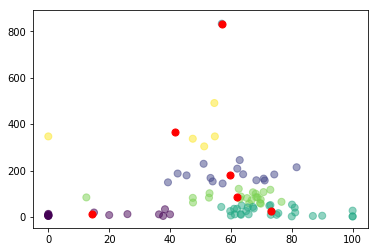

In [43]:
plt.scatter(kmc_df['subjectivity_mean'], kmc_df['top_tag_count'], c=kmeans.labels_.astype(float),
            s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50);

In [150]:
# New data in - 20 May 2019, 1:40PM PST

large_videos_df = pd.read_csv('new_videos_2.csv')
lg_videos_comments_df = pd.read_csv('video_comments_2.csv')
lg_videos_descrips_df = pd.read_csv('video_descriptions_2.csv')

In [152]:
print(large_videos_df.shape)
print(lg_videos_comments_df.shape)
lg_videos_descrips_df.shape

(578, 4)
(586, 3)


(595, 5)

In [155]:
comments_descrips_df = pd.merge(lg_videos_comments_df, lg_videos_descrips_df,
                                how='inner', on=['video_id'])

In [156]:
videos_all_df = pd.merge(large_videos_df, comments_descrips_df,
                         how='inner', on=['video_id'])

In [159]:
videos_all_df = videos_all_df.drop(['id_y', 'video_title_y'], axis=1)

In [161]:
videos_all_df = videos_all_df.rename(columns={'video_title_x': 'video_title',
                                              'id_x': 'id'})
videos_all_df.head()

,video_title,video_id,moods,labeled,id,comments,video_description,predicted_moods
0,Disfigure - Hollah! FREE DUBSTEP Creative Comm...,ZzsWXK-MKME,HAPPY,t,524,[],♫ Please Subscribe to Creative Commons Music F...,NaN
1,♩♫ Dramatic Apocalyptic Music ♪♬ - The Wastela...,5eAalHA1bAc,CHILL,t,56,"['Linda composição!!!', 'Who is here from real...",INSTAGRAM! : https://instagram.com/rossbugden/...,NaN
2,Zend Music | Mendum - Elysium [NCS Release] | ...,sCfVL8mULEA,ANGRY,t,497,['Zend Music | Mendum - Elysium [NCS Release] ...,Zend Music | Mendum - Elysium [NCS Release] | ...,NaN
3,Zend Music | JPB - High [NCS Release] | Free M...,sCcGq9g5iA4,HAPPY,t,501,['Zend Music | JPB - High [NCS Release] | Free...,Zend Music | JPB - High [NCS Release] | Free M...,NaN
4,Nostalgy - (No Copyright Music) Sad Cinematic ...,zViXwVZpWqY,SAD,t,442,['Download this music track: http://bit.ly/2QC...,Download Music: http://bit.ly/2QC9e3K (No Copy...,NaN


In [162]:
videos_all_df.shape

(578, 8)

In [176]:
len(videos_all_df[videos_all_df.comments=='[]'])

211

In [170]:
labeled_videos_df = videos_all_df[videos_all_df.labeled=='t']

In [177]:
labeled_videos_df.to_csv('labeled_videos.csv')

In [171]:
unlabeled_videos_df = videos_all_df[videos_all_df.labeled !='t']

In [175]:
unlabeled_videos_df.tail()

,video_title,video_id,moods,labeled,id,comments,video_description,predicted_moods
573,Jordan Schor Marvin Divine - Want It All (Bas...,w2XlLDlge2c,HAPPY,NaN,1113,['Mantap gan music nya'],"Jangan Lupa LIKE, SHARE & SUBSCRIBE ^_^\n\n\nN...",NaN
574,Cinematic Motivational - Telifsiz Müzik - No ...,RpGcUrP6Qzs,HAPPY,NaN,1114,[],Download Music: http://bit.ly/2Gsq6H3 (No Copy...,NaN
575,Snow Falling Animation | 4K |With Royalty Free...,2d3vBG8VfiM,HAPPY,NaN,1115,[],Snow Falling Animation | 4K | With Royalty Fre...,NaN
576,DRW – Programmer [House] from Royalty Free Pla...,l3vEtwBRGPE,HAPPY,NaN,1116,"['Fleeting tune, jams!!!', 'I am glad that I f...",Royalty Free Planet is home to the best qualit...,NaN
577,FUTURE SHOCK - No Copyright Music - Elelectro ...,RNd5JYLL-z0,HAPPY,NaN,1117,"['Bella Brother!', 'Inquietantemente, ipnotica...",Elelectro dance music FREE DOWNLOAD\nno copyri...,NaN


In [178]:
unlabeled_videos_df.to_csv('unlabeled_videos.csv')

In [103]:
tags_columns = ['polarity_mean', 'subjectivity_mean', 'tags', 'tags_count', 'top_tag', 'top_tag_count',
                'second_tag', 'second_tag_count', 'third_tag', 'third_tag_count']
lg_videos_comments_df = pd.concat([lg_videos_comments_df, pd.DataFrame(columns=tags_columns)], axis=1)

In [104]:
lg_videos_comments_df.shape

(539, 14)

In [105]:
lg_videos_comments_df = lg_videos_comments_df[lg_videos_comments_df.comments != '[]']

In [106]:
lg_videos_comments_df.shape

(337, 14)

In [107]:
for comments in lg_videos_comments_df.comments.values:
    populate_blob_columns(lg_videos_comments_df, comments)

[('NN', 43), ('JJ', 19), ('IN', 14)] len(c.most_common(3)) is: 3
[('NN', 40), ('JJ', 10), ('FW', 5)] len(c.most_common(3)) is: 3
[('NN', 180), ('JJ', 51), ('FW', 38)] len(c.most_common(3)) is: 3
[('NN', 43), ('JJ', 16), ('DT', 9)] len(c.most_common(3)) is: 3
[('NN', 65), ('JJ', 31), ('DT', 20)] len(c.most_common(3)) is: 3
[('NN', 117), ('IN', 61), ('DT', 54)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 9), ('VB', 6)] len(c.most_common(3)) is: 3
[('NNP', 19), ('NN', 10), ('CD', 5)] len(c.most_common(3)) is: 3
[('NN', 120), ('NNP', 37), ('IN', 27)] len(c.most_common(3)) is: 3
[('NN', 168), ('IN', 83), ('VB', 83)] len(c.most_common(3)) is: 3
[('NN', 187), ('JJ', 43), ('FW', 39)] len(c.most_common(3)) is: 3
[('NN', 616), ('JJ', 177), ('FW', 109)] len(c.most_common(3)) is: 3
[('NN', 11), ('PRP', 7), ('VB', 5)] len(c.most_common(3)) is: 3
[('NN', 165), ('JJ', 52), ('FW', 49)] len(c.most_common(3)) is: 3
[('NN', 84), ('FW', 20), ('JJ', 15)] len(c.most_common(3)) is: 3
[('NN', 43), ('JJ', 

[('NN', 54), ('JJ', 17), ('DT', 7)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 3), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 47), ('IN', 29), ('DT', 22)] len(c.most_common(3)) is: 3
[('NN', 63), ('DT', 27), ('JJ', 26)] len(c.most_common(3)) is: 3
[('NN', 7), ('JJ', 4), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 7), ('NNS', 3), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 11), ('JJ', 9), ('RB', 8)] len(c.most_common(3)) is: 3
[('NN', 105), ('JJ', 50), ('IN', 42)] len(c.most_common(3)) is: 3
[('JJ', 3), ('NN', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 78), ('JJ', 25), ('NNS', 10)] len(c.most_common(3)) is: 3
[('NN', 9), ('PRP$', 3), ('NNS', 2)] len(c.most_common(3)) is: 3
[('NN', 5), ('VB', 3), ('JJ', 3)] len(c.most_common(3)) is: 3
[('NN', 12)] len(c.most_common(3)) is: 1
[('NN', 3), ('VB', 3), ('NNS', 2)] len(c.most_common(3)) is: 3
[('NN', 217), ('JJ', 47), ('NNP', 41)] len(c.most_common(3)) is: 3
[('NN', 16), ('JJ', 6), ('DT', 5)] len(c.most_common(3)) is: 3
[

[('NN', 47), ('DT', 20), ('IN', 17)] len(c.most_common(3)) is: 3
[('NN', 42), ('JJ', 15), ('IN', 10)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 4), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 4), ('PRP$', 2), ('JJ', 2)] len(c.most_common(3)) is: 3
[('NN', 43), ('RB', 9), ('VB', 9)] len(c.most_common(3)) is: 3
[('NN', 6), ('NNS', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 7), ('VB', 3), ('MD', 2)] len(c.most_common(3)) is: 3
[('JJ', 1)] len(c.most_common(3)) is: 1
[('NN', 77), ('JJ', 20), ('VB', 20)] len(c.most_common(3)) is: 3
[('NN', 7), ('IN', 4), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 9), ('NNP', 6), ('JJ', 4)] len(c.most_common(3)) is: 3
[('NN', 117), ('IN', 33), ('VB', 27)] len(c.most_common(3)) is: 3
[('NN', 60), ('DT', 14), ('IN', 13)] len(c.most_common(3)) is: 3
[('NN', 61), ('DT', 27), ('IN', 22)] len(c.most_common(3)) is: 3
[('NN', 79), ('IN', 18), ('VB', 15)] len(c.most_common(3)) is: 3
[('NN', 81), ('IN', 25), ('PRP', 23)] len(c.most_common(3)) is: 3

In [125]:
print(lg_videos_comments_df.shape)
lg_videos_comments_df.head()
lg_videos_comments_df.tags_count.describe()

(337, 14)


count     337
unique    182
top        14
freq       13
Name: tags_count, dtype: int64

#### End Sandbox

### Creating a Doc2Vec NLP model

As mentioned at the beginning, this was considered but ultimately set aside in favor of TextBlob.

In [ ]:
# make a Doc2Vec TaggedDocument for each video's comments;
# append each of those Doc2Vec TaggedDocuments to a "sentences" list;
# create: model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1);
# call: model.build_vocab(sentences);
# train model: for epoch in range(int):... model.train, model.alpha, model.min_alpha

In [ ]:
sentences = []
sentences_ordered_dict = OrderedDict()
sent_count = 0
raw_comments = list(comments_df.comments.values)  # this is all of the comments for all videos
for comment_group in raw_comments:
    sent_key = 'sentence' + str(sent_count)
    sentences_ordered_dict[sent_key] = doc2vec.TaggedDocument(
        words=comment_group, tags=["SENT_" + str(sent_count)])
    sentences.append(sentences_ordered_dict[sent_key])
    sent_count += 1
print('TaggedDocument count in sentences is:', len(sentences), '\n')
print(sentences[0])

In [ ]:
# Create doc2vec model and build its vocabulary
model = Doc2Vec(alpha=.025, min_alpha=.025, min_count=2)
model.build_vocab(sentences)

In [ ]:
# Get more info about the model
print(model)

In [ ]:
# Find out which objects related to vocabulary are available in the Doc2Vec namespace
[x for x in dir(model) if 'vocab' in x]

In [ ]:
# Look closer at 'vocabulary'
help(model.vocabulary)

In [ ]:
# infer new tokens on new comments documents